# Hitting Patterns: Decoding Vladimir Guerrero Jr's Swing Probability.ipynb

<p style="text-align: justify;">
This analysis seeks to predict the likelihood of Vladimir Guerrero Jr swinging at a specific pitch, based on factors such as pitch characteristics (e.g., speed, horizontal and vertical break, pitch type), at-bat situation (balls and strikes), and the previous pitch faced.
</p>

<p style="text-align: justify;">
The insights gained from this study can be applied in several ways. For pitchers, understanding the pitches Guerrero is most likely to swing at can aid in creating more effective scouting reports, helping to identify weaknesses or preferred pitch types and locations. From a batter's perspective, Guerrero can use this analysis to gain a deeper understanding of his own tendencies and potentially improve his pitch selection and decision-making at the plate.
</p>

<p style="text-align: justify;">
While this particular study is limited to Blue Jays' Vladimir Guerrero Jr, it can be reproduced for different players as well. Additionally, a similar study from a pitcher's perspective can also be carried out to understand the type of pitches where the pitcher is getting the batter to swing.
</p>





### **Step I: Data Collection**

In [106]:
# pip install pybaseball

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import statcast_batter, statcast_pitcher, playerid_lookup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.metrics import classification_report, accuracy_score
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV


pd.set_option('display.max_columns', None)

In [108]:
#Find the playerid for the batter
playerid_lookup('guerrero', 'vladimir')

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,guerrero,vladimir,665489,guerv002,guerrvl02,19611,2019.0,2024.0
1,guerrero,vladimir,115223,guerv001,guerrvl01,778,1996.0,2011.0


The pitch-by-pitch data for Guerrero Jr over the last 5 seasons can be generated using the `statcast_batter()` call

In [109]:
#Get the pitch-by-pitch data for Guerrero over the last 5 seasons using his key_mlbam
data_complete = statcast_batter('2020-01-01', '2024-12-31', 665489)

Gathering Player Data


In [110]:
data_complete.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,ST,2024-09-29,84.5,3.27,5.51,"Guerrero Jr., Vladimir",665489,677960,strikeout,swinging_strike,NaN,NaN,NaN,NaN,13.0,Vladimir Guerrero Jr. strikes out swinging.,R,R,L,TOR,MIA,S,2.0,NaN,2,2,2024,-0.54,-0.03,-0.09,0.84,NaN,NaN,NaN,2,5,Bot,NaN,NaN,NaN,NaN,NaN,NaN,-6.699328,-122.788993,-4.386035,-4.057558,25.837819,-31.802006,3.62,1.63,NaN,NaN,NaN,83.8,2459.0,6.0,744880,663743,681146,672640,681393,669364,665052,667472,660821,54.46,NaN,0.0,0.0,1.0,0.0,0.0,NaN,40,5,Sweeper,0,2,0,2,2,0,0,2,Infield shade,Standard,305.0,-0.014,-0.084,71.0,8.8,NaN,0.084,NaN,-2,-2,0.225,0.225,24,25,25,25,3,2,5.0,1.0,NaN,NaN,3.25,-0.54,0.54,33.3
1,FF,2024-09-29,95.5,2.86,5.85,"Guerrero Jr., Vladimir",665489,677960,NaN,ball,NaN,NaN,NaN,NaN,11.0,Vladimir Guerrero Jr. strikes out swinging.,R,R,L,TOR,MIA,B,NaN,NaN,1,2,2024,0.67,0.92,-1.07,2.86,NaN,NaN,NaN,2,5,Bot,NaN,NaN,NaN,NaN,NaN,NaN,-11.761651,-138.506284,-4.250574,11.310222,31.035235,-19.484983,3.65,1.68,NaN,NaN,NaN,94.6,2291.0,6.0,744880,663743,681146,672640,681393,669364,665052,667472,660821,54.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,4,4-Seam Fastball,0,2,0,2,2,0,0,2,Infield shade,Standard,140.0,0.000,0.015,NaN,NaN,NaN,-0.015,NaN,-2,-2,0.225,0.225,24,25,25,25,3,2,5.0,1.0,NaN,NaN,1.59,0.67,-0.67,40.6
2,ST,2024-09-29,84.8,2.95,5.68,"Guerrero Jr., Vladimir",665489,677960,NaN,ball,NaN,NaN,NaN,NaN,13.0,Vladimir Guerrero Jr. strikes out swinging.,R,R,L,TOR,MIA,B,NaN,NaN,0,2,2024,-0.98,-0.05,-0.15,1.11,NaN,NaN,NaN,2,5,Bot,NaN,NaN,NaN,NaN,NaN,NaN,-5.247828,-123.377331,-4.155511,-8.739594,27.238153,-32.037396,3.68,1.71,NaN,NaN,NaN,83.9,2485.0,6.0,744880,663743,681146,672640,681393,669364,665052,667472,660821,54.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,3,Sweeper,0,2,0,2,2,0,0,2,Infield shade,Standard,320.0,0.000,0.009,NaN,NaN,NaN,-0.009,NaN,-2,-2,0.225,0.225,24,25,25,25,3,2,5.0,1.0,NaN,NaN,3.25,-0.98,0.98,37.7
3,CH,2024-09-29,87.8,3.13,5.56,"Guerrero Jr., Vladimir",665489,677960,NaN,foul,NaN,NaN,NaN,NaN,12.0,Vladimir Guerrero Jr. strikes out swinging.,R,R,L,TOR,MIA,S,NaN,NaN,0,1,2024,0.98,0.31,1.12,2.80,NaN,NaN,NaN,2,5,Bot,NaN,NaN,NaN,NaN,NaN,NaN,-6.859079,-127.721461,-1.195147,12.188265,26.730530,-28.768895,3.62,1.63,213.0,83.3,59.0,87.1,2025.0,5.9,744880,663743,681146,672640,681393,669364,665052,667472,660821,54.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,2,Changeup,0,2,0,2,2,0,0,2,Infield shade,Standard,111.0,0.000,-0.022,77.1,7.6,NaN,0.022,88.0,-2,-2,0.225,0.225,24,25,25,25,3,2,5.0,1.0,NaN,NaN,2.65,0.98,-0.98,31.5
4,SI,2024-09-29,94.6,2.92,5.72,"Guerrero Jr., Vladimir",665489,677960,NaN,foul,NaN,NaN,NaN,NaN,5.0,Vla

<div>
</div>

### **Step II: Feature Selection**

In [111]:
data_complete.description.unique()

array(['swinging_strike', 'ball', 'foul', 'hit_into_play', 'blocked_ball',
       'foul_tip', 'called_strike', 'swinging_strike_blocked',
       'hit_by_pitch', 'pitchout'], dtype=object)

We can filter out certain pitches where the objective of the pitch is not to get the batter to swing. For example, we see that the dataset includes 'pitchout' pitches where the intent of the pitcher is to get a base runner out, instead of getting Guerrero to swing at the pitch.



In [112]:
data_complete = data_complete.loc[data_complete.description!='pitchout']


We will begin predicting whether Vladimir Guerrero Jr is likely to swing at a pitch based on the following features:
1. **Location of the Pitch**
  * plate_x, plate_z: represents the horizontal and vertical position of the ball (from the catcher's perspective) when it crosses the home plate
2. **Speed of the Pitch**
  * release_speed: out of hand pitch velocity
  * vx0, vy0, vz0: velocity of the pitch in x,y and z dimension determined at y=50 feet
3. **Vertical and Horizontal Break of the Pitch**
  * pfx_x, pfx_z: vertical and horizontal movement of the pitch (from catcher's perspective)
4. **Game Situation**
  * strikes, balls: pre-pitch number of strikes and balls in count
5. **Details about the Pitcher**
  * p_throws: hand the pitcher throws with
6. **Details about the Previous Pitch**
  * What was the kind of previous pitch thrown



In [113]:
data = data_complete[['game_date','plate_x','plate_z','release_speed','p_throws','pfx_x','pfx_z','vx0','vy0','vz0','strikes','balls','description','pitch_type','pitch_number','pitcher']].copy()
data.head()

,game_date,plate_x,plate_z,release_speed,p_throws,pfx_x,pfx_z,vx0,vy0,vz0,strikes,balls,description,pitch_type,pitch_number,pitcher
0,2024-09-29,-0.09,0.84,84.5,L,-0.54,-0.03,-6.699328,-122.788993,-4.386035,2,2,swinging_strike,ST,5,677960
1,2024-09-29,-1.07,2.86,95.5,L,0.67,0.92,-11.761651,-138.506284,-4.250574,2,1,ball,FF,4,677960
2,2024-09-29,-0.15,1.11,84.8,L,-0.98,-0.05,-5.247828,-123.377331,-4.155511,2,0,ball,ST,3,677960
3,2024-09-29,1.12,2.80,87.8,L,0.98,0.31,-6.859079,-127.721461,-1.195147,1,0,foul,CH,2,677960
4,2024-09-29,0.26,2.26,94.6,L,1.48,1.04,-10.093681,-137.284932,-5.526671,0,0,foul,SI,1,677960


In [114]:
data.shape

(11858, 16)

In [115]:
pd.concat([data.isna().sum(), data.isna().sum() / data.shape[0]], axis=1, keys=['Count', 'Percentage'])

,Count,Percentage
game_date,0,0.000000
plate_x,75,0.006325
plate_z,75,0.006325
release_speed,75,0.006325
p_throws,0,0.000000
pfx_x,75,0.006325
pfx_z,75,0.006325
vx0,75,0.006325
vy0,75,0.006325
vz0,75,0.006325


The number of records for which values such as plate_x, plate_z, pfx_x, pfx_z, vx0, vy0 and vz0 are missing is the same. These records with missing data are just 0.6% of the total records, and thus can simply be dropped.

If the number of records with missing values was very high, methods such as KNN or MICE Imputation could have been explored.


In [116]:
#Remove records which have a missing value for plate_x, plate_z, pitch_type or release speed
data = data.dropna(subset = ['plate_x', 'plate_z', 'pitch_type', 'release_speed'])
print(data.shape)

(11783, 16)


<div>
</div>

### **Step III: Feature Engineering**




> **Create a new variable for the previous pitch type**

In [117]:
# The get the data of the previous pitch, we will have to ensure that the records are in chronological order
data = data.iloc[::-1].reset_index(drop=True) #to ensure that the most earliest innings is on top

# Group the data by game_date before shifting the pitch_type variable downwards
# We make an assumption that the pitch type of the last pitch Guerrero faced today, will not impact his decision to swing or not on the next day's first pitch
data['prev_pitch'] = data.groupby('game_date')['pitch_type'].shift(1)

# Create a category for the first pitch that Guerrero faces on each day
data['prev_pitch'] = data['prev_pitch'].fillna('first')

data.head()

,game_date,plate_x,plate_z,release_speed,p_throws,pfx_x,pfx_z,vx0,vy0,vz0,strikes,balls,description,pitch_type,pitch_number,pitcher,prev_pitch
0,2020-07-21,1.47,1.45,78.4,R,1.45,-0.36,3.758187,-114.095825,-0.077956,0,0,ball,SL,1,543901,first
1,2020-07-21,0.98,1.69,89.2,R,-1.38,0.36,9.638985,-129.648792,-2.846369,0,1,called_strike,SI,2,543901,SL
2,2020-07-21,0.93,1.87,77.8,R,1.41,-0.52,2.996298,-113.240706,1.161410,1,1,hit_into_play,SL,3,543901,SI
3,2020-07-21,1.66,1.48,77.4,R,1.39,-0.27,4.623130,-112.632502,0.041347,0,0,ball,SL,1,543901,SL
4,2020-07-21,0.84,2.79,88.4,R,-1.65,0.07,9.866922,-128.464689,0.620241,0,1,called_strike,SI,2,543901,SL


> **Categorize the Pitch Type into 3 Groups**

In [118]:
data['pitch_type'].unique()

array(['SL', 'SI', 'CH', 'FF', 'CU', 'ST', 'FC', 'FS', 'KC', 'FA', 'SV',
       'EP', 'FO', 'KN'], dtype=object)

In [119]:
#The pitchtype currently contains 15 different categories which can be split into 3 major categories
#This has been done to avoid creating a seperate dummy variable for each particular pitch type

fastball = ['FF','SI', 'FC', 'FA']
breaking = ['CU','SL','KC','KN','FS', 'ST', 'SV']
offspeed = ['CH','FO','EP']

data['pitch_type'] = np.where(data['pitch_type'].isin(fastball), 'fastball', data['pitch_type'])
data['pitch_type'] = np.where(data['pitch_type'].isin(breaking), 'breaking', data['pitch_type'])
data['pitch_type'] = np.where(data['pitch_type'].isin(offspeed), 'offspeed', data['pitch_type'])

data['prev_pitch'] = np.where(data['prev_pitch'].isin(fastball), 'fastball', data['prev_pitch'])
data['prev_pitch'] = np.where(data['prev_pitch'].isin(breaking), 'breaking', data['prev_pitch'])
data['prev_pitch'] = np.where(data['prev_pitch'].isin(offspeed), 'offspeed', data['prev_pitch'])

print(data['pitch_type'].unique())
print(data['prev_pitch'].unique())

['breaking' 'fastball' 'offspeed']
['first' 'breaking' 'fastball' 'offspeed']


> **Create the target variable (Swing At Pitch?)**

In [120]:
data['description'].unique()

array(['ball', 'called_strike', 'hit_into_play', 'swinging_strike',
       'foul_tip', 'foul', 'swinging_strike_blocked', 'blocked_ball',
       'hit_by_pitch'], dtype=object)

In [121]:
#Create the target variable swing which will eventually represent whether Guerrero swung at the pitch or not
data['swing'] = 1

#Update the swing column for pitches where Guerrero did not swing at the ball
data['swing'] = np.where(data['description'].isin(['ball','blocked_ball','called_strike', 'hit_by_pitch']),0,1)

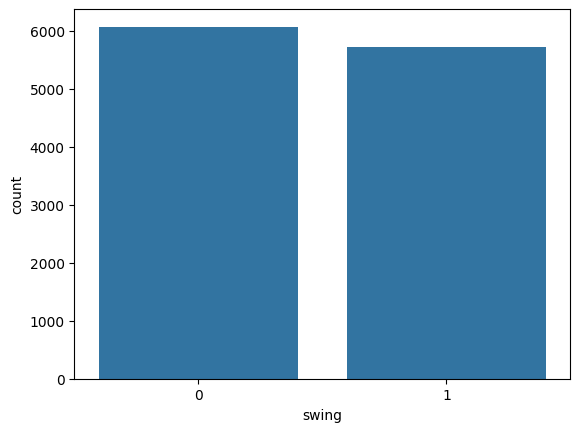

'The dataset in fairly balanced in terms of pitches at which Guerrero did and did not swing. As a result, no class balancing techniques such as oversampling or undersampling is required'

In [122]:
sns.countplot(data=data, x='swing')
plt.show()
"""The dataset in fairly balanced in terms of pitches at which Guerrero did and did not swing. As a result, no class balancing techniques such as oversampling or undersampling is required"""

In [123]:
data.head()

,game_date,plate_x,plate_z,release_speed,p_throws,pfx_x,pfx_z,vx0,vy0,vz0,strikes,balls,description,pitch_type,pitch_number,pitcher,prev_pitch,swing
0,2020-07-21,1.47,1.45,78.4,R,1.45,-0.36,3.758187,-114.095825,-0.077956,0,0,ball,breaking,1,543901,first,0
1,2020-07-21,0.98,1.69,89.2,R,-1.38,0.36,9.638985,-129.648792,-2.846369,0,1,called_strike,fastball,2,543901,breaking,0
2,2020-07-21,0.93,1.87,77.8,R,1.41,-0.52,2.996298,-113.240706,1.161410,1,1,hit_into_play,breaking,3,543901,fastball,1
3,2020-07-21,1.66,1.48,77.4,R,1.39,-0.27,4.623130,-112.632502,0.041347,0,0,ball,breaking,1,543901,breaking,0
4,2020-07-21,0.84,2.79,88.4,R,-1.65,0.07,9.866922,-128.464689,0.620241,0,1,called_strike,fastball,2,543901,breaking,0


<div>
</div>

### **Step IV: EDA**

<Figure size 1500x1000 with 0 Axes>

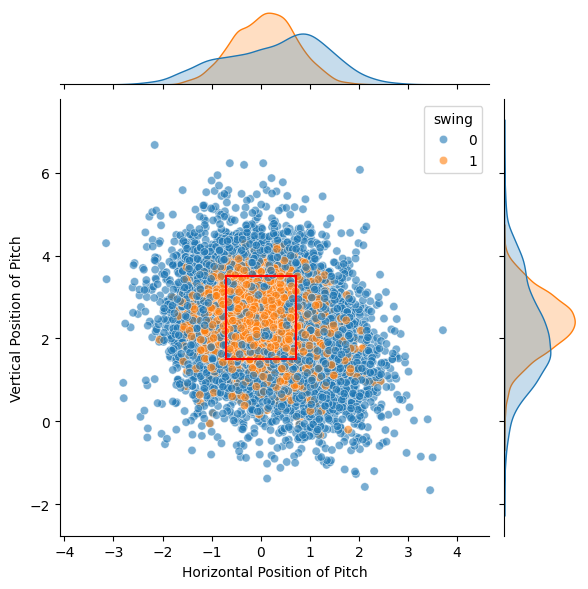

In [124]:
plt.figure(figsize=(15,10))
sns.jointplot(data = data, x = 'plate_x', y = 'plate_z', hue = 'swing', alpha = 0.6)

#Add the rough strike box (note: Original strike box coordinates will change depending on the height of the player at bat)
plt.plot([-0.71, 0.71], [1.50, 1.50], color = 'red')
plt.plot([-0.71, 0.71], [3.50, 3.50], color = 'red')
plt.plot([-0.71, -0.71], [1.50, 3.50], color = 'red')
plt.plot([0.71, 0.71], [1.50, 3.50], color = 'red')

plt.xlabel("Horizontal Position of Pitch")
plt.ylabel("Vertical Position of Pitch")
plt.show()
plt.show()

As anticipated, the swing pitches (highlighted in orange) are concentrated near the center of the plot, predominantly within the strike zone. In contrast, the no-swing pitches are more widely dispersed beyond the strike zone's boundaries. However, an intriguing pattern emerges—while swings outside the zone are expectedly less frequent, there is a noticeably greater spread of swings on the left side (closer to Guerrero's body) of the plate compared to the right (away from Guerrero).

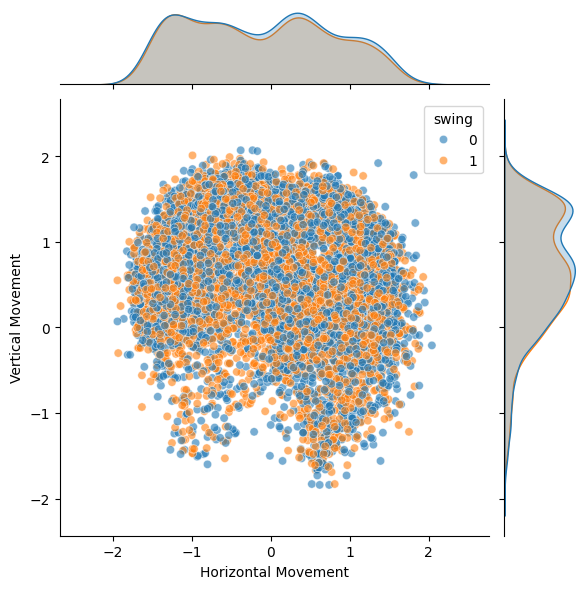

In [125]:
sns.jointplot(data = data, x = 'pfx_x', y = 'pfx_z', hue = 'swing', alpha = 0.6)
plt.xlabel("Horizontal Movement")
plt.ylabel("Vertical Movement")
plt.show()

The distinction between swing and no-swing pitches becomes far less pronounced when analyzing the pitch's horizontal and vertical movement

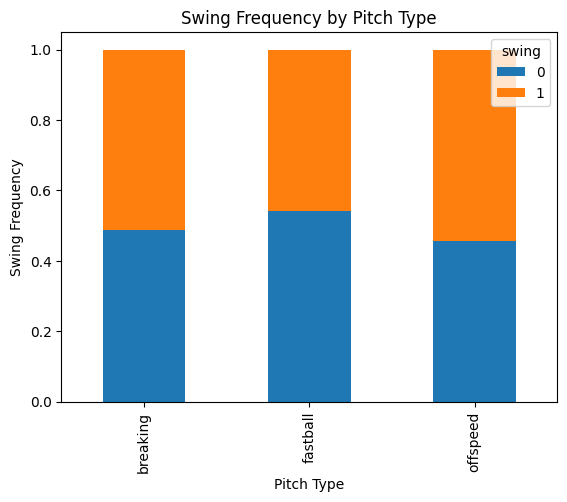

In [126]:
cross_tab = pd.crosstab(data['pitch_type'], data['swing'], normalize='index')
cross_tab.plot(kind='bar', stacked=True)
plt.title('Swing Frequency by Pitch Type')
plt.xlabel('Pitch Type')
plt.ylabel('Swing Frequency')
plt.show()

Guerrero has a slightly highly tendency to swing at offspeed pitches, compared to fastball.

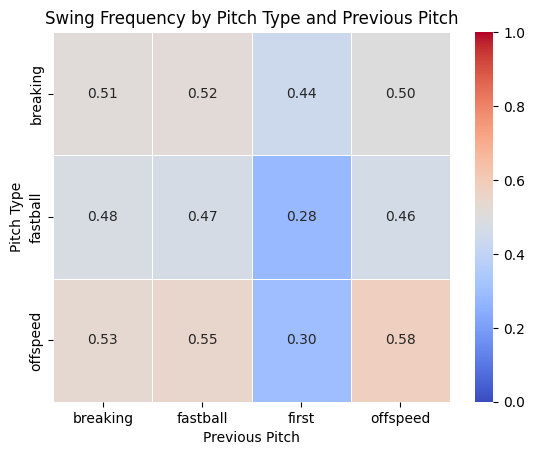

In [127]:
cross_tab_multiple = pd.crosstab(data['pitch_type'], data['prev_pitch'], data['swing'], aggfunc='mean')
sns.heatmap(cross_tab_multiple, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=0, vmax=1)
plt.title('Swing Frequency by Pitch Type and Previous Pitch')
plt.xlabel('Previous Pitch')
plt.ylabel('Pitch Type')
plt.show()

We notice that Guerrero has a very low tendency to swing at this first pitch, especially if its a fastball. On the other hand, if both, the previous and current pitches are offspeed, Guerrero has a high swing probability.

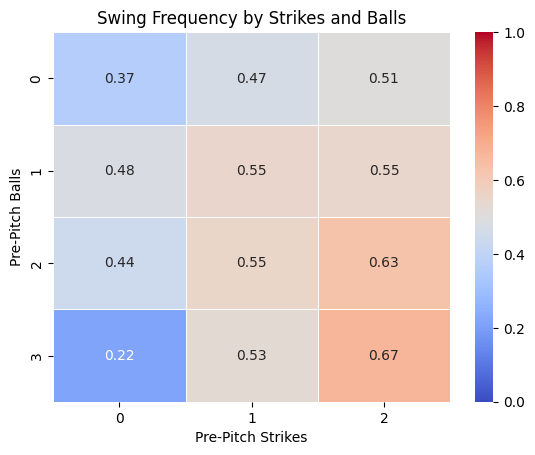

In [128]:
cross_tab_multiple_situation = pd.crosstab(data['balls'], data['strikes'], data['swing'], aggfunc='mean')
sns.heatmap(cross_tab_multiple_situation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=0, vmax=1)
plt.title('Swing Frequency by Strikes and Balls')
plt.xlabel('Pre-Pitch Strikes')
plt.ylabel('Pre-Pitch Balls')
plt.show()

The probability of Guerrero swinging at a pitch increases signigicantly if he is on 2 strikes.

<div>
</div>

### **Step V: Preparing Data for ML Model**

In [129]:
data.head()

,game_date,plate_x,plate_z,release_speed,p_throws,pfx_x,pfx_z,vx0,vy0,vz0,strikes,balls,description,pitch_type,pitch_number,pitcher,prev_pitch,swing
0,2020-07-21,1.47,1.45,78.4,R,1.45,-0.36,3.758187,-114.095825,-0.077956,0,0,ball,breaking,1,543901,first,0
1,2020-07-21,0.98,1.69,89.2,R,-1.38,0.36,9.638985,-129.648792,-2.846369,0,1,called_strike,fastball,2,543901,breaking,0
2,2020-07-21,0.93,1.87,77.8,R,1.41,-0.52,2.996298,-113.240706,1.161410,1,1,hit_into_play,breaking,3,543901,fastball,1
3,2020-07-21,1.66,1.48,77.4,R,1.39,-0.27,4.623130,-112.632502,0.041347,0,0,ball,breaking,1,543901,breaking,0
4,2020-07-21,0.84,2.79,88.4,R,-1.65,0.07,9.866922,-128.464689,0.620241,0,1,called_strike,fastball,2,543901,breaking,0


In [130]:
data = data[['pitcher', 'plate_x', 'plate_z', 'release_speed', 'p_throws', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'strikes', 'balls', 'pitch_type', 'prev_pitch', 'swing']]

In [131]:
# Create dummy variables for categorical columns
data_dummies = pd.get_dummies(data, columns=['p_throws', 'pitch_type', 'prev_pitch'], drop_first=True)
data_dummies.head()

,pitcher,plate_x,plate_z,release_speed,pfx_x,pfx_z,vx0,vy0,vz0,strikes,balls,swing,p_throws_R,pitch_type_fastball,pitch_type_offspeed,prev_pitch_fastball,prev_pitch_first,prev_pitch_offspeed
0,543901,1.47,1.45,78.4,1.45,-0.36,3.758187,-114.095825,-0.077956,0,0,0,True,False,False,False,True,False
1,543901,0.98,1.69,89.2,-1.38,0.36,9.638985,-129.648792,-2.846369,0,1,0,True,True,False,False,False,False
2,543901,0.93,1.87,77.8,1.41,-0.52,2.996298,-113.240706,1.161410,1,1,1,True,False,False,True,False,False
3,543901,1.66,1.48,77.4,1.39,-0.27,4.623130,-112.632502,0.041347,0,0,0,True,False,False,False,False,False
4,543901,0.84,2.79,88.4,-1.65,0.07,9.866922,-128.464689,0.620241,0,1,0,True,True,False,False,False,False


In [132]:
X = data_dummies.drop(['swing', 'pitcher'], axis=1)
y = data_dummies['swing']

In [133]:
X.describe()

,plate_x,plate_z,release_speed,pfx_x,pfx_z,vx0,vy0,vz0,strikes,balls
count,11783.000000,11783.000000,11783.000000,11783.000000,11783.000000,11783.000000,11783.000000,11783.000000,11783.000000,11783.000000
mean,0.199992,2.265537,89.518145,-0.128292,0.639836,3.384313,-130.174652,-4.062654,0.846813,0.897055
std,0.875587,0.982582,5.936280,0.912363,0.687365,5.524032,8.589925,3.079791,0.815760,0.983402
min,-3.150000,-1.660000,47.700000,-1.940000,-1.840000,-16.105319,-149.983705,-16.541347,0.000000,0.000000
25%,-0.400000,1.630000,85.300000,-0.940000,0.210000,1.138544,-137.171527,-6.109905,0.000000,0.000000
50%,0.220000,2.270000,90.200000,-0.150000,0.670000,4.725522,-131.177187,-4.160331,1.000000,1.000000
75%,0.800000,2.890000,94.400000,0.590000,1.210000,7.121582,-124.039224,-2.044410,2.000000,2.000000
max,3.710000,6.670000,103.300000,2.040000,2.070000,19.268554,-69.069104,9.169543,2.000000,3.000000


We notice that the range of plate_x (-3.2 to 3.7) varies significantly from that of the release speed (47.7 to 103.3). As a result, will standardize the features to ensure that all features are given an equal importance. Since the data contains a mix of numerical and binary variables, we will use a Min-Max Scaler.

In [134]:
#Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [135]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

### **Step VI: Building the ML Model**

> **Base Logistic Regression Model**

To begin with, we will create a simple logistic regression model that can be used as our base model. The logistic regression model will help us generate an initial intuition of how the features impact the probability of swing, and create a benchmark that our final model must beat.

In [136]:
logreg = sm.Logit(y_train.values.reshape(-1,1), X_train_scaled).fit()

Optimization terminated successfully.
         Current function value: 0.654021
         Iterations 5


In [137]:
print(logreg.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 9426
Model:                          Logit   Df Residuals:                     9410
Method:                           MLE   Df Model:                           15
Date:                Wed, 05 Feb 2025   Pseudo R-squ.:                 0.05574
Time:                        18:23:09   Log-Likelihood:                -6164.8
converged:                       True   LL-Null:                       -6528.7
Covariance Type:            nonrobust   LLR p-value:                2.189e-145
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
plate_x                -2.1731      0.273     -7.949      0.000      -2.709      -1.637
plate_z                 2.6055      0.386      6.752      0.000       1.849       3.362
release_speed   

Initial Insights:
1. plate_x, plate_z, release_speed, strikes, balls, pitch_type_fastball all have a very small p-value - statistically significant in determining whether Guerrero will swing at a given pitch
2. Features associated with Higher Probability of Guerrero Swinging:
  * Higher Vertical Position
  * Higher Pre-Pitch Strike Count
  * Higher Pre-Pitch Ball Count
3. Features associated with Lower Probability of Guerrero Swinging:
  * Higher Horizontal Position
  * Fastball

In [138]:
# Predict probabilities for test set
logreg_predictions = logreg.predict(X_test_scaled)
logreg_predictions = list(map(round, logreg_predictions))

In [139]:
print(classification_report(y_test, logreg_predictions))
print("Test Set Accuracy = ", round(accuracy_score(y_test, logreg_predictions), 3))

              precision    recall  f1-score   support

           0       0.61      0.67      0.64      1204
           1       0.62      0.56      0.59      1153

    accuracy                           0.61      2357
   macro avg       0.61      0.61      0.61      2357
weighted avg       0.61      0.61      0.61      2357

Test Set Accuracy =  0.614


> **LightGBM Classifier Model**

In [172]:
#Create a parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [4, 6, 8, 10, 12],
    'min_child_samples': [1, 5, 10, 15, 20]
}

#Create a lightGBM model and train it using the training set
gbm = lgb.LGBMClassifier(verbose=-1)

#Create the gridsearch model
model = GridSearchCV(estimator=gbm, param_grid=param_grid, cv = 5)
model.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(verbose=-1),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'max_depth': [4, 6, 8, 10, 12],
                         'min_child_samples': [1, 5, 10, 15, 20],
                         'n_estimators': [50, 100, 150, 200, 250, 300]})

In [174]:
best_params = model.best_params_
print(best_params)

best_model = model.best_estimator_

{'learning_rate': 0.05, 'max_depth': 8, 'min_child_samples': 20, 'n_estimators': 150}


In [175]:
#Predict the swing probabilities for the test set
gbm_pred=best_model.predict(X_test_scaled)

In [176]:
# Create the Classification Report for the test set predictions
print(classification_report(y_test, gbm_pred))

# Determine the test set accuracy of the model
print('Test accuracy = ', round(accuracy_score(y_test, gbm_pred),3))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1204
           1       0.77      0.80      0.79      1153

    accuracy                           0.79      2357
   macro avg       0.79      0.79      0.79      2357
weighted avg       0.79      0.79      0.79      2357

Test accuracy =  0.789


The performance of the LightGBM model is better than that of the initial logistic regression model.

<div>
</div>

### **Application**

The initial logistic regression model provided valuable insights into the key features influencing Vladimir Guerrero Jr.'s likelihood of swinging. It also helped identify the characteristics of pitches that made him more or less inclined to take a swing.  

However, applying this model to predict whether Guerrero will swing at a given pitch is not the most effective approach. Instead, a more insightful strategy involves leveraging visualizations to explore swing probabilities across different pitch zones and attributes. This allows for a more intuitive understanding of a hitter's tendencies and the factors that shape their decision-making at the plate.

We start by focussing on Guerrero's probability of swinging at pitches thrown by a particular pitcher -  543037 (Cole Gerrit)



In [153]:
#Filter out records to only include pitches thrown by ___________
data_vis = data_dummies.loc[data_dummies['pitcher']==543037].copy()

X_vis = data_vis.drop(['swing', 'pitcher'], axis=1)
y_vis = data_vis['swing']

#Scale the data
scaler = MinMaxScaler()
X_vis_scaled = pd.DataFrame(scaler.fit_transform(X_vis), columns=X_vis.columns)

#Build and train the LightGBM Model
gbm_vis = lgb.LGBMClassifier(verbose=-1)
gbm_vis.fit(X_vis_scaled, y_vis)

#Predict the swing probability for all records
gbm_vis_prob = gbm_vis.predict_proba(X_vis_scaled)[:,1]

In [159]:
#Create the final dataset which includes the characteristics of the pitch + probability of Guerrero swinging at them
data_vis = data.loc[data['pitcher']==543037].copy()
data_vis['swing_probability'] = gbm_vis_prob
print(data_vis.shape)
data_vis.head()

(162, 16)


,pitcher,plate_x,plate_z,release_speed,p_throws,pfx_x,pfx_z,vx0,vy0,vz0,strikes,balls,pitch_type,prev_pitch,swing,swing_probability
746,543037,0.37,1.99,96.4,R,-1.02,1.47,8.268368,-139.865868,-7.247636,0,0,fastball,fastball,0,0.007216
747,543037,-0.31,3.04,96.9,R,-1.20,1.52,7.115602,-140.833995,-4.548495,1,0,fastball,fastball,1,0.909102
748,543037,0.35,1.59,86.4,R,0.50,0.10,4.248948,-125.893842,-3.908774,0,0,breaking,fastball,1,0.722930
749,543037,0.71,1.72,88.8,R,0.56,0.29,5.186908,-129.247715,-4.233995,1,0,breaking,breaking,1,0.931217
750,543037,1.12,1.69,88.2,R,0.60,0.16,5.973391,-128.329213,-3.804124,2,0,breaking,breaking,0,0.065049


#### **Pitch Position vs. Swing Probability**

Text(0.5, 1.0, "Guerrero's probability of swinging based on Pitch Position")

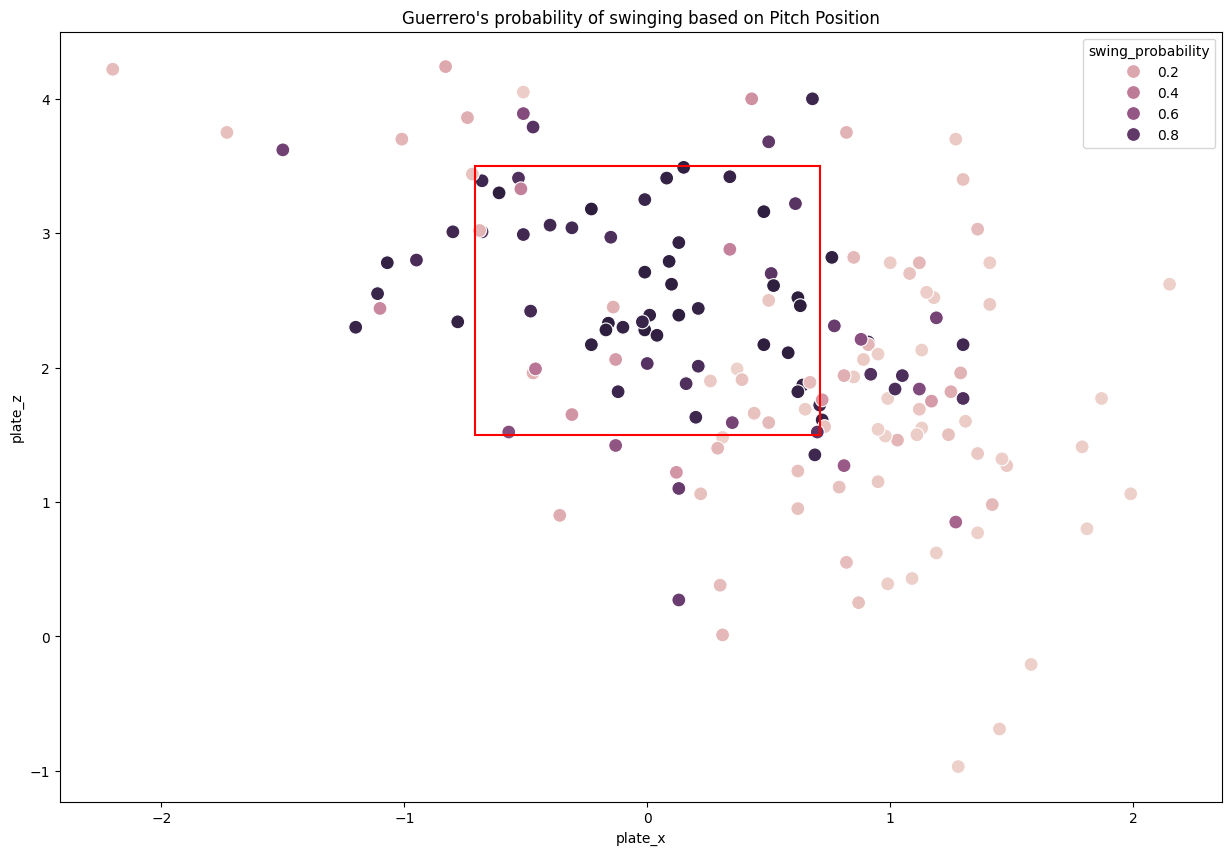

In [170]:
#Plot the position of the pitch when it crosses home plate, along with the probability of Guerrero swinging at it
plt.figure(figsize=(15,10))
sns.scatterplot(x = data_vis.plate_x, y = data_vis.plate_z, hue = data_vis.swing_probability, s = 100)

#Add the rough strike box (note: Original strike box coordinates will change depending on the height of the player at bat)
plt.plot([-0.71, 0.71], [1.50, 1.50], color = 'red')
plt.plot([-0.71, 0.71], [3.50, 3.50], color = 'red')
plt.plot([-0.71, -0.71], [1.50, 3.50], color = 'red')
plt.plot([0.71, 0.71], [1.50, 3.50], color = 'red')

plt.title("Guerrero's probability of swinging based on Pitch Position")

As expected, Guerrero demonstrates a higher probability of swinging at pitches located within the strike zone. This aligns with fundamental hitting tendencies, as pitches in the zone are generally more hittable and enticing to batters.

#### **Pitch Position & Pitch Type vs. Swing Probability**

Text(0.5, 1.0, "Guerrero's probability of swinging based on pitch position and pitch type")

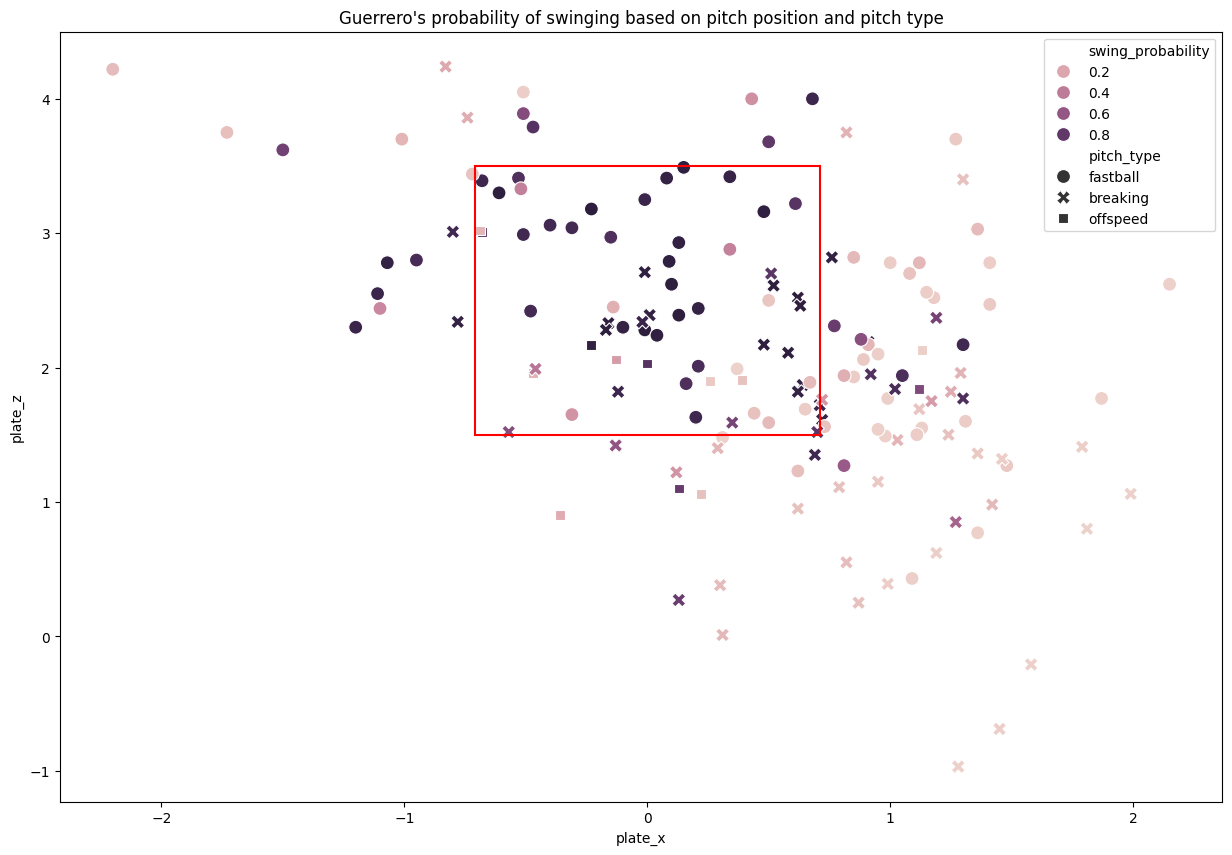

In [162]:
#Plot the position of the pitch when it crosses home plate, along with the probability of Guerrero swinging at it.
#Differentiate the pitches based on the pitch type
plt.figure(figsize=(15,10))
sns.scatterplot(x = data_vis.plate_x, y = data_vis.plate_z, hue = data_vis.swing_probability, style=data_vis.pitch_type, s = 100)

#Add the rough strike box (note: Original strike box coordinates will change depending on the height of the player at bat)
plt.plot([-0.71, 0.71], [1.50, 1.50], color = 'red')
plt.plot([-0.71, 0.71], [3.50, 3.50], color = 'red')
plt.plot([-0.71, -0.71], [1.50, 3.50], color = 'red')
plt.plot([0.71, 0.71], [1.50, 3.50], color = 'red')

plt.title("Guerrero's probability of swinging based on pitch position and pitch type")

The insights from the initial visualization can be further refined by categorizing pitches into three types: fastballs, offspeed, and breaking pitches.

The data indicates that Guerrero is more likely to swing at fastballs that are located on the left side of the strike zone, closer to his body. Conversely, when examining pitches on the right side of the strike zone, his swing probability increases notably for breaking pitches compared to offspeed offerings.

This suggests that Guerrero may be more aggressive against fastballs in his inner half while showing a greater willingness to chase breaking pitches away. Understanding these nuanced tendencies provides deeper insight into his approach at the plate and how pitchers might look to exploit or counteract his preferences.

#### **Pre-Pitch Strikes vs. Swing Probability**

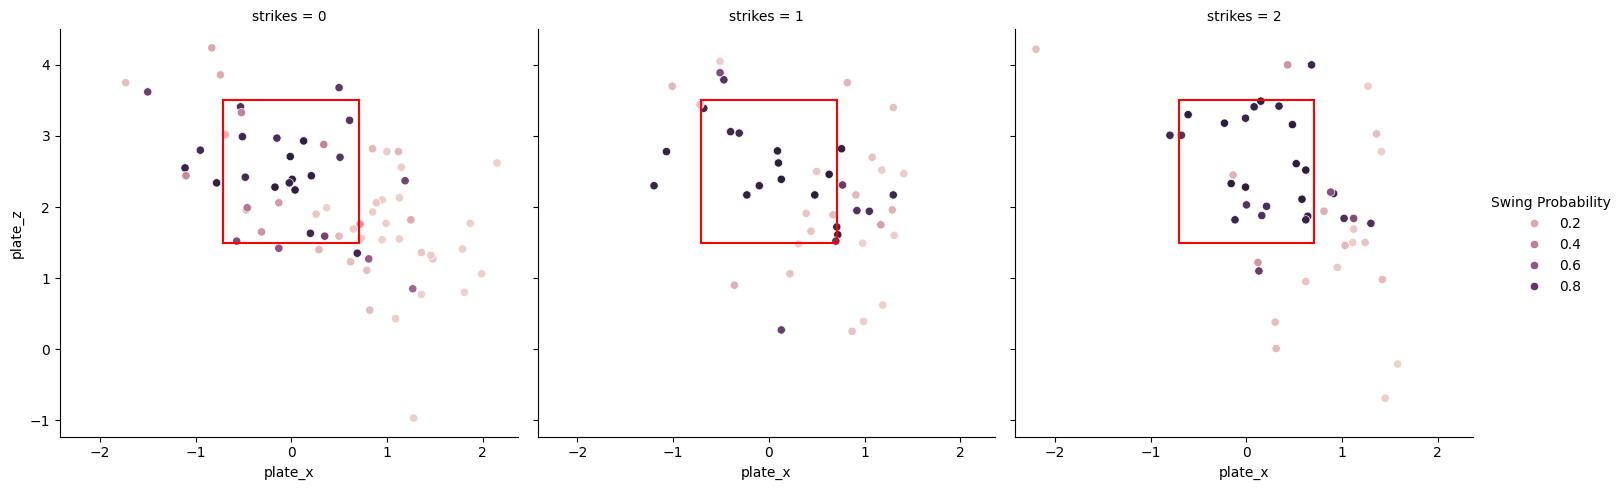

In [171]:
#Visualizing the impact of strikes on Guerrero's swing predictions
g = sns.FacetGrid(data_vis, col="strikes", aspect=1, height=5)
g.map_dataframe(sns.scatterplot, x="plate_x", y="plate_z", hue="swing_probability")
ax1, ax2, ax3 = g.axes[0]
ax1.plot([-0.71, 0.71], [1.50, 1.50], color = 'red')
ax1.plot([-0.71, 0.71], [3.50, 3.50], color = 'red')
ax1.plot([-0.71, -0.71], [1.50, 3.50], color = 'red')
ax1.plot([0.71, 0.71], [1.50, 3.50], color = 'red')
ax2.plot([-0.71, 0.71], [1.50, 1.50], color = 'red')
ax2.plot([-0.71, 0.71], [3.50, 3.50], color = 'red')
ax2.plot([-0.71, -0.71], [1.50, 3.50], color = 'red')
ax2.plot([0.71, 0.71], [1.50, 3.50], color = 'red')
ax3.plot([-0.71, 0.71], [1.50, 1.50], color = 'red')
ax3.plot([-0.71, 0.71], [3.50, 3.50], color = 'red')
ax3.plot([-0.71, -0.71], [1.50, 3.50], color = 'red')
ax3.plot([0.71, 0.71], [1.50, 3.50], color = 'red')
g.add_legend(title = 'Swing Probability')

#plt.title("Guerrero's probability of swinging based on pitch position and number of strikes")

The final visualization delves into the variation in Vladimir Guerrero Jr.'s swing probabilities based on the number of strikes he has accumulated. The chart reveals a notable trend: when Guerrero finds himself with one or two strikes, his likelihood of swinging at pitches on the right side, outside the strike zone, escalates considerably compared to when he has a no-strike count.

Conversely, his probability of swinging at pitches on the left side of the strike zone appears to remain relatively stable, regardless of the number of strikes he has faced. This suggests that Guerrero's swing decisions are more influenced by the number of strikes when facing pitches on the right side, while his tendencies on the left side remain consistent throughout the count.


### Conclusion

This study focused on predicting the probability of Vladimir Guerrero Jr swinging at a pitch, leveraging various pitch characteristics and game situations to generate insights. Through this analysis, we identified the key factors that influence Guerrero's decision to swing, allowing us to develop a high-accuracy predictive model.

The second part of the study explored the practical applications of this model for both the Toronto Blue Jays and opposing teams. We visualized how variables such as pitch location, pitch type, and strike count all affect Guerrero's swing probability. This data could prove invaluable to scouts, offering guidance on how to pitch to Guerrero based on the specific context of the game.

There are several potential avenues for expanding this study, such as applying the model and insights to other batters and pitchers. Additionally, incorporating further features—like the game's at-bat context (e.g., the number of players on base) or a player's performance in previous at-bats—could provide even more nuanced predictions.
